In [1]:
%load_ext autoreload
%autoreload 2

# Dropout as a Bayesian Approximation

We have already introduced a few concepts that are popular among the neural networks community. These include standard neural networks and their bayesian formulation. However, training bayesian neural nets can be daunting: you have to implement initialization carefully and store twice as many parameters. It also requires retraining (so no knowledge transfer between neural networks can happen), and the learning process has high variance. 

To tackle these problems [Yarin Gal and Zoubin Ghahramani in "Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"](https://arxiv.org/abs/1506.02142) asked the following question: is it possible to approximate the bayesian behavior using existing well-established techniques? The answer is yes, and you will find out the solution in that notebook.

## Dropout as an approximation of Gaussian Processes 

We have already shown you how the dropout technique works. It bases on sampling mask from the bernoulli mask with a probability $1 - p$ as $M \sim B(1 - p)$ and multiply layers inputs by that mask as $\hat{x} = x \odot M$, where $\odot$ is a hadamard product (elementwise multiplication). This operation is performed during training and turned off during validation. What if we left the dropout during the validation?

It turns out that we get other architecture of the same neural network. Thanks to the possibility of multiple samplings, we get a Gaussian Process with a covariance function marginalized over its weights.

## Model uncertainty

For recall, the predictive distribution for a pair $(x, y)$ of test point and weights $\theta$ is equal to:

$$
q(y | x) = \int p(y | x; \theta) q(\theta)\, d\theta
$$

The equation can be understood as the integration over multiple instances of $\theta$, where multiple of these instances are obtained by multiple forward passes with dropout turned on. We have to find the first two raw moments (mean and standard deviation) to obtain the full uncertainty. These can be easily approximated through Monte Carlo sampling with $T$ samplings of bernoulli mask as:

$$
\mathbb{E}_{q(y|x)} \approx \frac{1}{T} \sum^T_{t=1} \hat{f}(x; \theta^t)
$$

where $\hat{f}$ is our neural network. Predictive variance however is equal to:

$$
\text{Var}_{q(y|x)}(y) \approx \tau^{-1} + \frac{1}{T}\sum^T_{t=1}\hat{f}(x; \theta^t)^2 - \mathbb{E}_{q(y|x)}^2 
$$

Note that these equations are simplified versions for the case when only a single scalar is predicted. Fortunately, if no dependencies occur between classes, then each predicted scalar in a vector can be treated independently (ex. for categorical prediction). For full derivation, please refer to the original work. 

Taking advantage of the central limit theorem, we can see that these equations lead to a description of normal distributions, where in fact, each forward inference uses bernoulli distribution. This where $\tau$ appears - square root of its inverse is our width of the normal distribution of multiple bernoulli trials. Recall that $\tau$ is an inverse of the variance. It is described as:

$$
\tau = \frac{(1 - p)l^2}{2N\lambda}
$$

where $p$ is a probability of the dropout, $N$ is the number of samples in the training data, $\lambda$ - $L_2$ strength, and $l$ - a prior scale of the distribution. Notice that with the increase of data, width decreases since we are given more data, and we are more sure about the predicted values. 


Note, that both moments simplify to normal mean and variance calculation of predictions.

Finally, we can obtain log-likelihood of the model as:

$$
\log p(y | x; \theta) \approx \text{logsumexp}\left(- \frac{1}{2} \tau (y - y^t)^2 \right) - \log T - \frac{1}{2}\log 2\pi - \frac{1}{2} \log \tau^{-1}
$$

$\text{logsumexp}$ trick is a mathematical equation, used in summing probabilites for a numerical stability. It is defined as:

$$
\text{logsumexp}\left(- \frac{1}{2} \tau (y - y^t)^2 \right) = \log\left( \sum^T_{t=1} \exp\left(-\frac{1}{2}\tau(y - y^t)^2\right) \right)
$$

It is implemented `pytorch` in method `torch.logsumexp(...)`


## Implementing Monte Carlo Dropout neural networks

You will work in the same setting as in the previous notebook. This includes the MNIST dataset and performed analysis. Your task is as follows:
- Implement a linear layer to turns dropout, no matter whether it is training or validation (use of `self.training` variable in the `nn.Module`)
- Implement calculating log-likelihood of predictions

In [2]:
import torch
import torch.nn as nn
import torch.distributions as dist
import torch.nn.functional as F
from src.nn import OwnSigmoid, OwnSoftmax, MSELoss

In [3]:
# implementing custom bayesian linear layer and sigmoid activation function

class MCDropoutLinear(nn.Linear):   # subclassing nn.Module, definition of our own bayesian fully connected layer
    """Main reference: https://arxiv.org/pdf/1505.05424.pdf"""
    def __init__(
        self, 
        num_input_features: int,  # number of input features
        num_output_features: int,  # number of output features
        use_bias: bool,  # whether to use bias
        probability: float,
    ):
        """Implement initialization of weights and biases values"""
        super().__init__(num_input_features, num_output_features, bias=use_bias)
        assert 0 <= probability <= 1
        
        # Layer structure
        self.num_input_features = num_input_features
        self.num_output_features = num_output_features
        self.dropout_p = probability
        
              
    def forward(self, x: torch.Tensor) -> torch.Tensor:        
        x = F.dropout(x,self.dropout_p, training=True) 
        return super().forward(x)

In [4]:
from torch import log 

class MCDropoutMLP(nn.Module):  # subclassing nn.Module, definition of our MC dropout multilayer perceptron
    def __init__(
        self, 
        num_input_features: int,  # number of input features (28 x 28 for MNIST)
        num_hidden_features: int,  # number of hidden units
        num_output_classes: int,  # number of output classes
        hidden_activation_function: type,  #  hidden activation function class
        output_activation_function: type,  # output activation function class
        probability: float,  # probability of the dropout
        train_data_size: int,  # size of the training data size, necessary for the tau parameter
        lengthscale: float = 1e-2,  # l parameter in tau,
        weight_decay: float = 1e-5,  # weight decay of L2
    ):
        """Implement neural network, similar to one in `0-NN` but with use of Bayesian layers"""
        super().__init__()
        
                
        self.layer_input_to_hidden = MCDropoutLinear(num_input_features, num_hidden_features, use_bias=True,probability=probability)
        self.layer_hidden_to_output = MCDropoutLinear(num_hidden_features, num_output_classes, use_bias=True,probability=probability)
        
        self.hidden_activation = hidden_activation_function()
        self.output_activation = output_activation_function()
        
        self.dropout_p = probability
        self.N = train_data_size
        self.pi = torch.tensor([0.5])
        self.l = torch.tensor([lengthscale])
        self.lmbda = torch.tensor([weight_decay])
        
        
    # definition of the forward inference
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Implement forward inference for MC dropout layers (single forward pass)"""
        x = self.layer_input_to_hidden(x)
        x = self.hidden_activation(x)
        x = self.layer_hidden_to_output(x)
        x = self.output_activation(x)
        return x
        
    def prediction_log_likelihood(self, predictions: torch.Tensor, true: torch.Tensor) -> torch.Tensor:
        """Implement calculation of model likelihood
        
        Predictions are in the form of N x K x T matrix, where N is a number
        of samples, K number of classes and T number of samplings while true - N x K.
        """
        
        N, K, T = predictions.shape
        true = true.repeat(1,T).view(-1, K, T)
        
        tau = ((1-self.dropout_p)*(self.l**2)) /(2*self.N*self.lmbda)
        error = torch.logsumexp(-0.5*tau*(true-predictions)**2,dim=(0,1)) 
        
        return error - torch.FloatTensor([T]).log() - 0.5*( (2*self.pi).log() + (1./tau).log())
        

In [5]:
from src import utils

In [6]:
train_data_size = 10_000
train_dataset, test_dataset = utils.load_mnist_datasets(limit_train_samples_to=train_data_size)

In [7]:
model = MCDropoutMLP(
    num_input_features=28 * 28,  # pixels
    num_hidden_features=128,  # arbitrary number
    num_output_classes=10,  # num of digits
    hidden_activation_function=OwnSigmoid,
    output_activation_function=OwnSoftmax,
    probability=0.4,
    train_data_size=train_data_size,
    lengthscale=1e-2,
    weight_decay=1e-5,
)

loss_fun = MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3, 
    weight_decay=1e-5
)

In [8]:
train_metrics, test_metrics = utils.fit_mc_dropout(
    model=model,
    train_dataset=train_dataset,
    valid_dataset=test_dataset,
    loss_function=loss_fun,
    batch_size=256,
    epochs=5,
    optimizer=optimizer,
    num_samplings=10
)

Epoch: 1 / 5



Epoch: 2 / 5



Epoch: 3 / 5



Epoch: 4 / 5



Epoch: 5 / 5


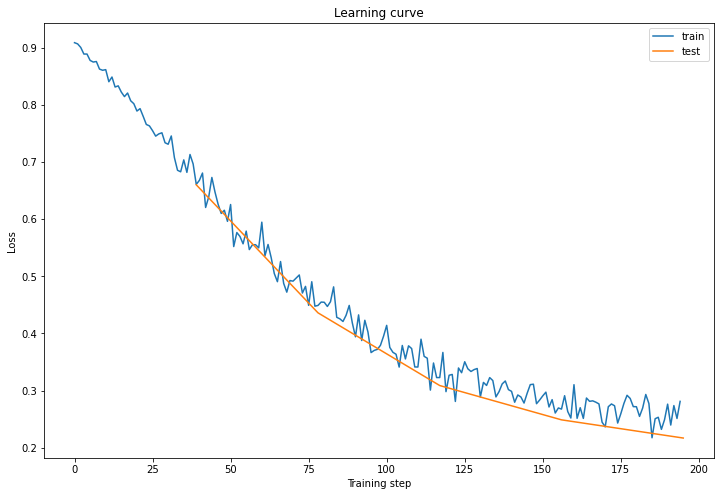

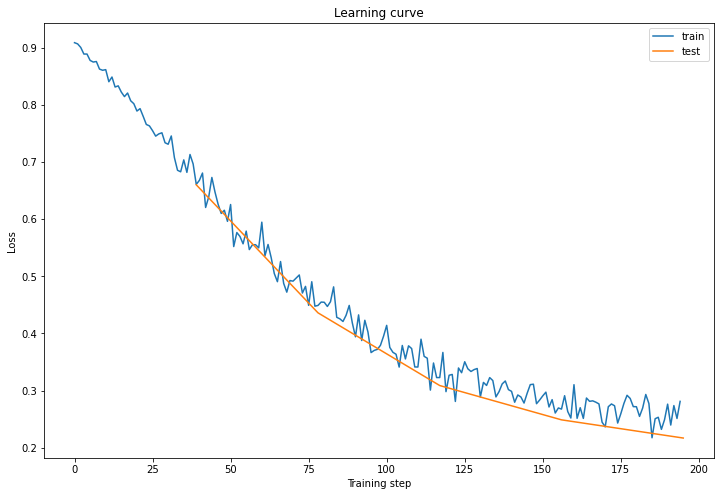

In [9]:
utils.show_learning_curve(train_metrics, test_metrics)

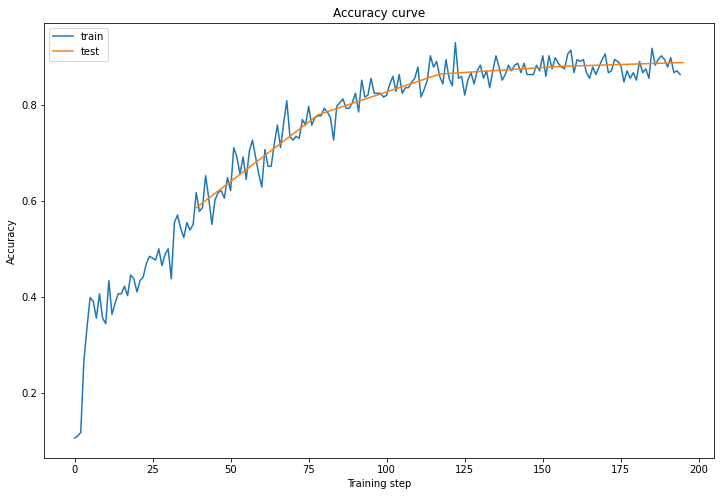

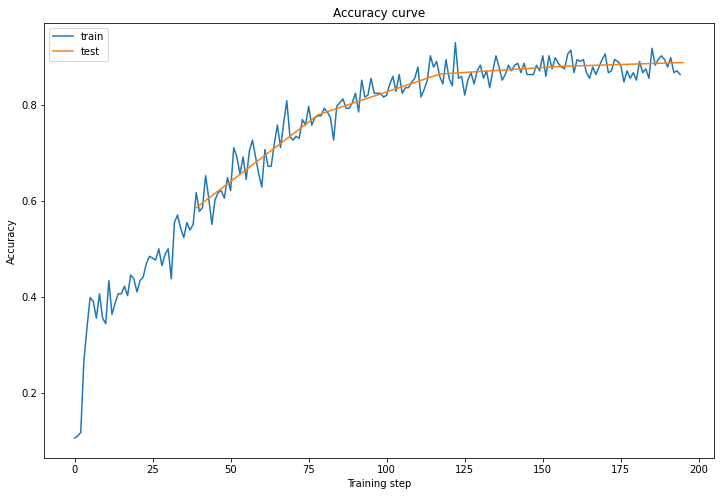

In [10]:
utils.show_accuracy_curve(train_metrics, test_metrics)

ValueError: only one element tensors can be converted to Python scalars

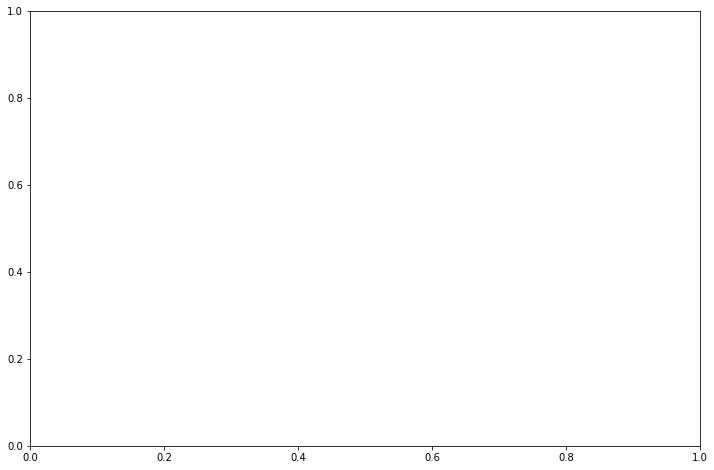

In [11]:
utils.show_log_prob_curve(train_metrics, test_metrics)

In [12]:
print(f"Best training accuracy: {max(train_metrics['acc'])}")
print(f"Best testing accuracy: {max(test_metrics['acc'])}")

Best training accuracy: 0.9296875
Best testing accuracy: 0.8883000016212463


In [13]:
num_samplings = 10
analyzer = utils.Analyzer(model, test_dataset, num_samplings)

Top high confidence correct predictions


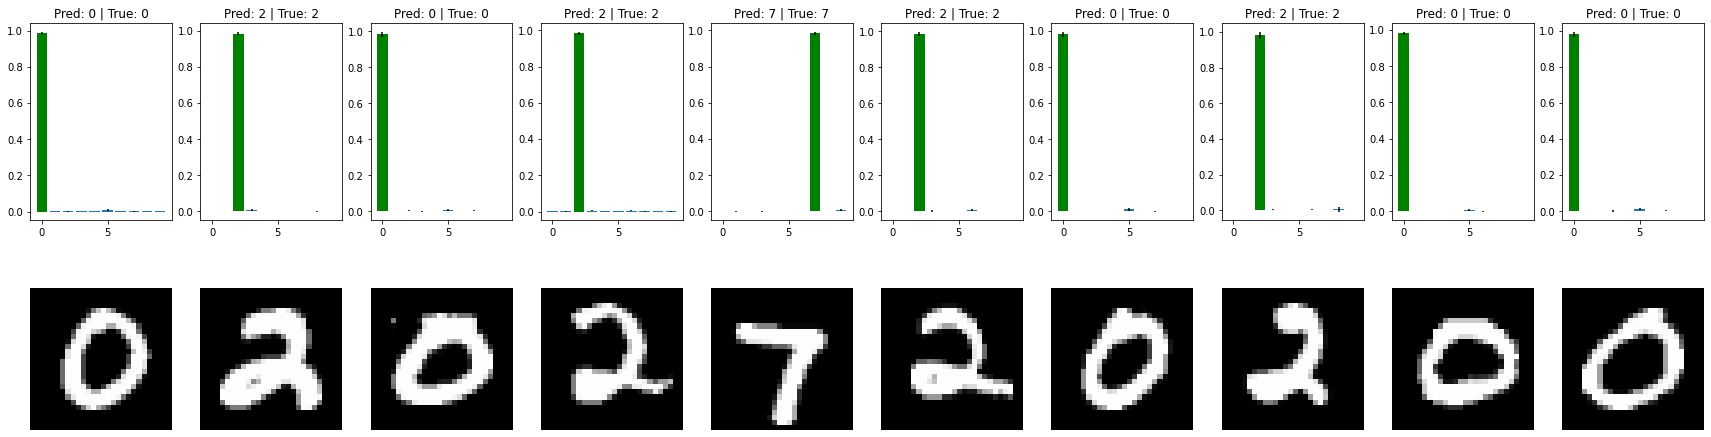

In [14]:
utils.visualize_samples(
    *analyzer.get_top_k_high_confidence_correct(10)
)
print("Top high confidence correct predictions")

Top low confidence correct predictions


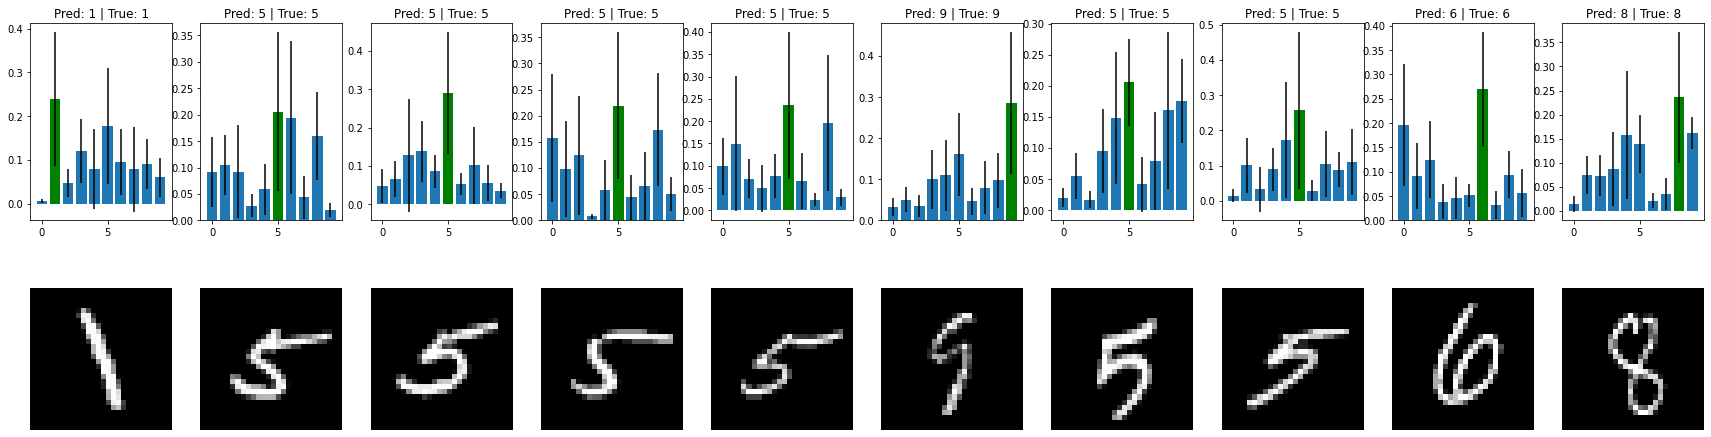

In [15]:
utils.visualize_samples(
    *analyzer.get_top_k_low_confidence_correct(10)
)
print("Top low confidence correct predictions")

## utils.visualize_samples(
    *analyzer.get_top_k_low_confidence_mistakes(10)
)

print("Top low confidence wrong predictions")

Top high confidence wrong predictions


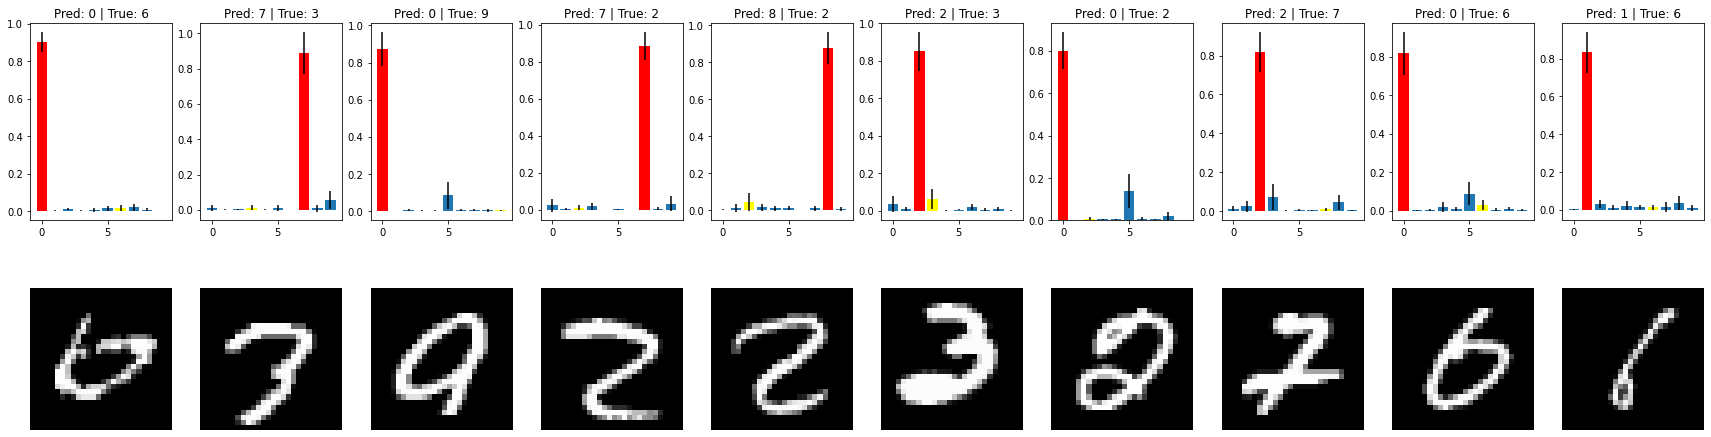

In [16]:
utils.visualize_samples(
    *analyzer.get_top_k_high_confidence_mistakes(10)
)

print("Top high confidence wrong predictions")

Histogram of weights for layer 1


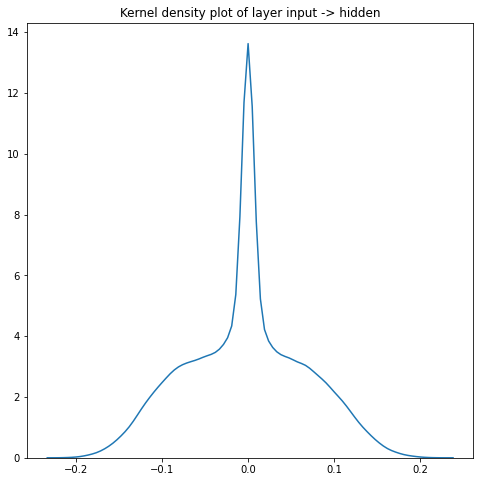

In [18]:
utils.visualize_weights(
    model.layer_input_to_hidden.weight,
    "layer input -> hidden"
)
print("Histogram of weights for layer 1")

Histogram of weights for layer 2


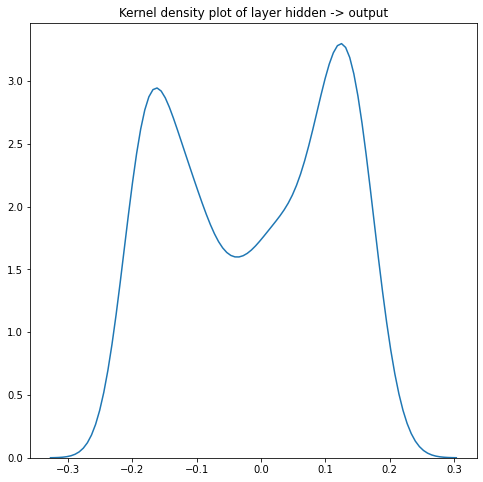

In [19]:
utils.visualize_weights(
    model.layer_hidden_to_output.weight,
    "layer hidden -> output"
)
print("Histogram of weights for layer 2")